In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import matplotlib.animation as animation
from IPython.display import HTML
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("My device: => ", device)

# Set random seed for reproducibility
random_seed = 123
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.use_deterministic_algorithms(True)

My device: =>  cuda:0


In [3]:
h = 64
w = 64
batch_size = 64
nc = 1
lr = 0.0002
beta1 = 0.5
root = "/kaggle/input/numta/training-c"


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


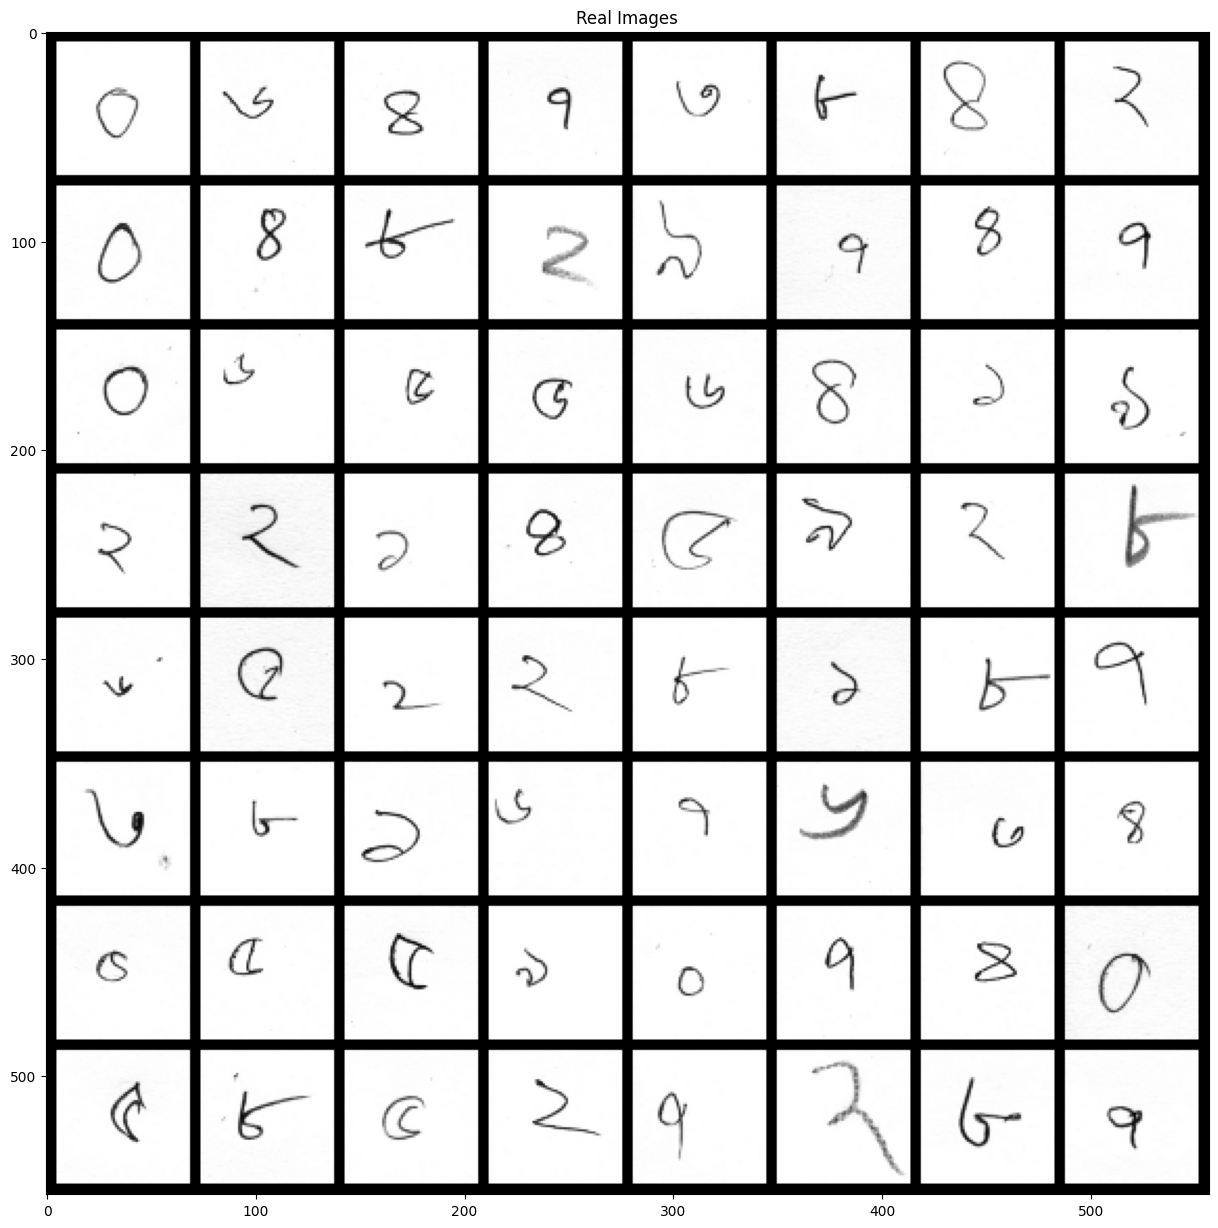

In [4]:
class ImageDataset(Dataset):
    def __init__(self, transform = None):
        self.imdb = []
        self.transform = transform
        self.load_files()
    
    def load_files(self):
        for file in os.listdir(root):
            self.imdb.append(os.path.join(root,file))

    def __len__(self):
        return len(self.imdb)
    
    def __getitem__(self, index):
        image = Image.open(self.imdb[index]).convert('L')
        image = self.transform(image)
        return image
        

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((h,w))])
dataset = ImageDataset(transform)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

dataiter = iter(data_loader)
images = next(dataiter)


plt.figure(figsize=(15,30))
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

                
        

In [5]:
class Generator(nn.Module):
    def __init__(self,latent_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self.get_gen_block(latent_dim, 512, kernel_size = 4,stride = 1,padding = 0, bias = False),
            self.get_gen_block(512, 256, kernel_size = 4,stride = 2,padding = 1, bias = False),
            self.get_gen_block(256,128, kernel_size = 4,stride = 2,padding = 1, bias = False),
            self.get_gen_block(128, 64, kernel_size = 4,stride = 2,padding = 1, bias = False),
            nn.ConvTranspose2d(64, nc, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
            
        )
    
    def forward(self, noise):
        return self.gen(noise)
    
    
    def get_gen_block(self,in_dim, out_dim, kernel_size, stride, padding, bias):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size = kernel_size, stride = stride, padding = padding, bias = bias),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(True)
        )
        
        return block
        

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(nc, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.disc(input)

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
gen = Generator().to(device)
gen.apply(weights_init)
print(gen)

disc = Discriminator().to(device)
disc.apply(weights_init)
print(disc)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [9]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(batch_size, 128, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

In [10]:
iters = 0
num_epochs = 100
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader, 0):
        # Train with all-real batch
        disc.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = disc(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128, 1, 1, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(0)
        # Classify all fake batch with D
        output = disc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(1)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/380]	Loss_D: 1.5559	Loss_G: 0.8671	D(x): 0.4907	D(G(z)): 0.4734 / 0.4734
[1/100][0/380]	Loss_D: 3.1262	Loss_G: 0.0460	D(x): 0.9981	D(G(z)): 0.9551 / 0.9551
[2/100][0/380]	Loss_D: 1.0911	Loss_G: 0.4105	D(x): 0.9992	D(G(z)): 0.6635 / 0.6635
[3/100][0/380]	Loss_D: 1.2149	Loss_G: 0.3526	D(x): 0.9997	D(G(z)): 0.7029 / 0.7029
[4/100][0/380]	Loss_D: 0.8336	Loss_G: 0.5706	D(x): 0.9995	D(G(z)): 0.5652 / 0.5652
[5/100][0/380]	Loss_D: 0.7331	Loss_G: 0.6551	D(x): 0.9998	D(G(z)): 0.5194 / 0.5194
[6/100][0/380]	Loss_D: 0.7080	Loss_G: 0.6788	D(x): 0.9998	D(G(z)): 0.5073 / 0.5073
[7/100][0/380]	Loss_D: 0.7427	Loss_G: 0.6461	D(x): 0.9999	D(G(z)): 0.5241 / 0.5241
[8/100][0/380]	Loss_D: 0.7697	Loss_G: 0.6222	D(x): 0.9999	D(G(z)): 0.5368 / 0.5368
[9/100][0/380]	Loss_D: 0.4510	Loss_G: 1.0138	D(x): 0.9998	D(G(z)): 0.3628 / 0.3628
[10/100][0/380]	Loss_D: 2.4042	Loss_G: 0.1010	D(x): 0.9412	D(G(z)): 0.9040 / 0.9040
[11/100][0/380]	Loss_D: 0.8686	Loss_G: 0.7212	D(x): 0.8294	D

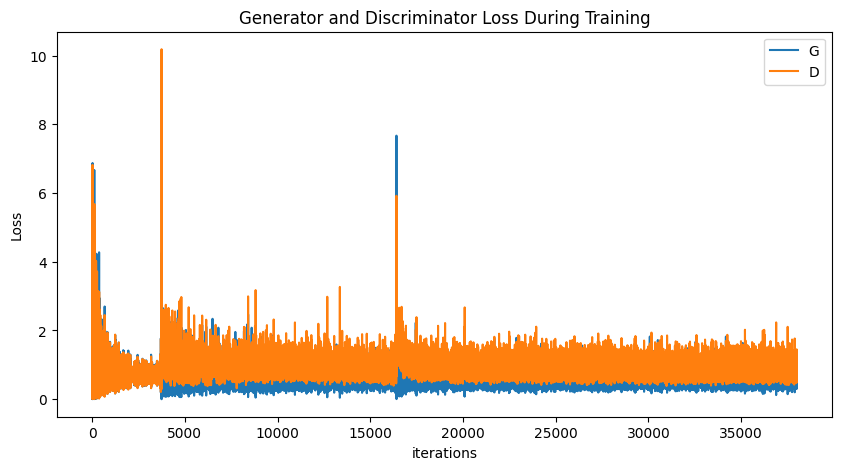

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

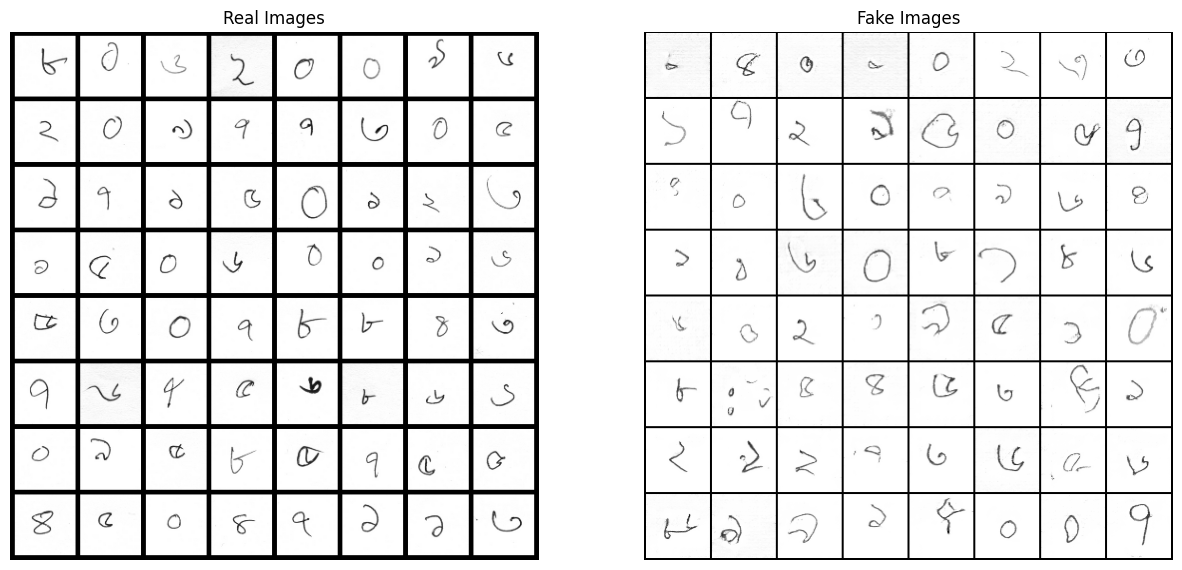

In [12]:
real_batch = next(iter(data_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()